f=1, g=0, crack: 0 degrees

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# Settings
torch.set_default_dtype(torch.float64)   # use double for better derivative precision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Domain: square [-1,1]^2 with crack along y=x starting from origin
X_MIN, X_MAX = -1.0, 1.0
Y_MIN, Y_MAX = -1.0, 1.0

# Training hyperparams
N_f = 4000       # collocation points
N_b_outer = 800  # boundary points on outer square
N_b_crack = 300  # boundary points on crack 
epochs = 100
#lr = 1e-3
lambda_bc = 1.0   # weight for BC loss
lambda_zz = 1.0   # weight for U_zz

def compute_phi(x, y):
    eps = 1e-12
    r = torch.sqrt(torch.clamp(x**2 + y**2, min=eps))
    phi = torch.sqrt(0.5 * (r - x))
    return phi.view(-1, 1)

def compute_phi_derivs(x, y):
    eps = 1e-12
    r = torch.sqrt(torch.clamp(x**2 + y**2, min=eps))
    phi_x = (-0.5) * (0.5**0.5) * torch.sqrt(r - x) / r
    phi_y = (0.25) * (2**0.5) * (y/r)/ torch.sqrt(r - x)

    return phi_x.reshape(-1,1), phi_y.reshape(-1,1)

In [21]:
# Neural network 
class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.ModuleList()
        for i in range(len(layers)-1):
            self.net.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = torch.tanh
        # init
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, inp):
        z = inp
        for layer in self.net[:-1]:
            z = self.activation(layer(z))
        z = self.net[-1](z)  # no activation on last
        return z

In [22]:
# Derivative 
def partials_U_wrt_inputs(model, x, y, phi):
    if x.dim() == 1:
        x = x.view(-1, 1)
    if y.dim() == 1:
        y = y.view(-1, 1)
    if phi.dim() == 1:
        phi = phi.view(-1, 1)

    inp = torch.cat([x, y, phi], dim=1).to(device) 
    inp.requires_grad_(True)

    U = model(inp)

    grads = torch.autograd.grad(U, inp, grad_outputs=torch.ones_like(U),
                                create_graph=True, retain_graph=True)[0]
    return U, inp, grads[:,0:1], grads[:,1:2], grads[:,2:3]

def second_partials_U(model, inp, U_x, U_y, U_z):
    grad_Ux = torch.autograd.grad(U_x, inp, grad_outputs=torch.ones_like(U_x),
                                  create_graph=True, retain_graph=True)[0]
    grad_Uy = torch.autograd.grad(U_y, inp, grad_outputs=torch.ones_like(U_y),
                                  create_graph=True, retain_graph=True)[0]
    grad_Uz = torch.autograd.grad(U_z, inp, grad_outputs=torch.ones_like(U_z),
                                  create_graph=True, retain_graph=True)[0]

    U_xx = grad_Ux[:,0:1]
    U_xz = grad_Ux[:,2:3]
    U_yy = grad_Uy[:,1:2]
    U_yz = grad_Uy[:,2:3]
    U_zz = grad_Uz[:,2:3]

    return U_xx, U_yy, U_xz, U_yz, U_zz

def compute_laplace_uN(model, x, y):
    phi = compute_phi(x, y)
    phi_x, phi_y = compute_phi_derivs(x, y)
    U, inp, U_x, U_y, U_z = partials_U_wrt_inputs(model, x, y, phi)
    U_xx, U_yy, U_xz, U_yz, U_zz = second_partials_U(model, inp, U_x, U_y, U_z)
    laplace_xU = U_xx + U_yy
    eps = 1e-12
    r = torch.sqrt(torch.clamp(x**2 + y**2, min=eps))
    lap = laplace_xU + 2*(U_xz * phi_x + U_yz * phi_y) + (1/(4*r))*U_zz
    return lap  # shape (N,1)

def compute_zz_uN(model):
    x = torch.tensor([[0.0]])
    y = torch.tensor([[0.0]])
    phi = compute_phi(x, y)
    U, inp, U_x, U_y, U_z = partials_U_wrt_inputs(model, x, y, phi)
    grad_Uz = torch.autograd.grad(U_z, inp, grad_outputs=torch.ones_like(U_z),
                                  create_graph=True, retain_graph=True)[0]
    U_xz = grad_Uz[:,0:1]
    U_yz = grad_Uz[:,1:2]
    U_zz = grad_Uz[:,2:3]

    return U_zz**2+U_xz**2+U_yz**2  # shape (N,1)

def compute_xyz_uN(model, x, y):
    phi = compute_phi(x, y)
    U, inp, U_x, U_y, U_z = partials_U_wrt_inputs(model, x, y, phi)
    grad_Uz = torch.autograd.grad(U_z, inp, grad_outputs=torch.ones_like(U_z),
                                  create_graph=True, retain_graph=True)[0]
    U_xz = grad_Uz[:,0:1]
    U_yz = grad_Uz[:,1:2]

    return U_xz**2+U_yz**2  # shape (N,1)

In [23]:
# Data sampling
def sample_collocation(N):
    x = torch.rand(N*2,1) * (X_MAX - X_MIN) + X_MIN
    y = torch.rand(N*2,1) * (Y_MAX - Y_MIN) + Y_MIN
    mask_crack = (torch.abs(y) < 1e-8) & (x >= 0.0)  # remove points on crack
    x, y = x[~mask_crack][:N], y[~mask_crack][:N]
    return x.to(device), y.to(device)

def sample_outer_boundary(N):
    per_side = max(4, N // 4)
    xs, ys = [], []
    ys.append(torch.linspace(Y_MIN, Y_MAX, per_side).unsqueeze(1)); xs.append(torch.ones_like(ys[-1]) * X_MIN)
    ys.append(torch.linspace(Y_MIN, Y_MAX, per_side).unsqueeze(1)); xs.append(torch.ones_like(ys[-1]) * X_MAX)
    xs.append(torch.linspace(X_MIN, X_MAX, per_side).unsqueeze(1)); ys.append(torch.ones_like(xs[-1]) * Y_MIN)
    xs.append(torch.linspace(X_MIN, X_MAX, per_side).unsqueeze(1)); ys.append(torch.ones_like(xs[-1]) * Y_MAX)
    x = torch.cat(xs, dim=0)[:N]; 
    y = torch.cat(ys, dim=0)[:N]
    return x.to(device), y.to(device)

def sample_crack_boundary(N):
    # 在 crack 取 N 個均勻點
    x_vals = torch.linspace(0, 1, N).unsqueeze(1).to(device)  
    y_vals = torch.zeros_like(x_vals).to(device)  # y=0

    return x_vals, y_vals


# model
layers = [3, 64, 64, 1]  
model = MLP(layers).to(device)

# Training data
x_f, y_f = sample_collocation(N_f)
x_b_out, y_b_out = sample_outer_boundary(N_b_outer)
x_b_crack, y_b_crack = sample_crack_boundary(N_b_crack)

with torch.no_grad():
    g_b_out = torch.zeros_like(x_b_out, device=device)
    g_b_crack = torch.zeros_like(x_b_crack, device=device)

x_b = torch.cat([x_b_out, x_b_crack])
y_b = torch.cat([y_b_out, y_b_crack])
g_b = torch.cat([g_b_out, g_b_crack])

# Validation Data 
x_val, y_val = sample_collocation(1000)
x_b_val, y_b_val = sample_outer_boundary(200)
g_b_val = torch.zeros_like(x_b_val)

loss_history = []
epo = []
val_history = []
epo_val = []

In [24]:
optimizer = optim.LBFGS(model.parameters(), lr=1.0, max_iter=20, history_size=50, line_search_fn="strong_wolfe")

print("Start training with LBFGS on device:", device)

for ep in range(epochs):

    def closure():
        optimizer.zero_grad()
        # PDE loss
        lap_u = compute_laplace_uN(model, x_f, y_f)  # shape (N_f,1)
        residual = -lap_u -1.0  # f=1
        loss_pde = torch.mean(residual**2)

        loss_zz = compute_zz_uN(model)

        loss_yxz = torch.mean(compute_xyz_uN(model, x_b_crack, y_b_crack))

        # boundary loss
        phi_b = compute_phi(x_b, y_b)
        inp_bc = torch.cat([x_b, y_b, phi_b.detach()], dim=1)
        u_bc = model(inp_bc)
        loss_bc = torch.mean((u_bc - g_b)**2)

        loss = loss_pde + lambda_bc * loss_bc + lambda_zz * loss_zz + lambda_zz * loss_yxz
        loss.backward()
        return loss

    loss = optimizer.step(closure)   # closure 被 optimizer 多次呼叫

    epo.append(ep)
    loss_history.append(loss.item())

    if ep % 10 == 0 or ep == epochs-1:
        
        # Validation Loss 
        x_val.requires_grad_(True)
        y_val.requires_grad_(True)

        lap_u_val = compute_laplace_uN(model, x_val, y_val)
        residual_val = -lap_u_val - 1.0
        loss_pde_val = torch.mean(residual_val**2)

        loss_zz = compute_zz_uN(model)

        with torch.no_grad():
            phi_b_val = compute_phi(x_b_val, y_b_val)
            inp_bc_val = torch.cat([x_b_val, y_b_val, phi_b_val], dim=1)
            u_bc_val = model(inp_bc_val)
            loss_bc_val = torch.mean((u_bc_val - g_b_val)**2)

        loss_val = loss_pde_val + lambda_bc * loss_bc_val  + lambda_zz * loss_zz

        epo_val.append(ep)
        val_history.append(loss_val.item())

        # 不需再追蹤梯度
        x_val.requires_grad_(False)
        y_val.requires_grad_(False)

        print(f"Epoch {ep:5d} | Train Loss {loss.item():.3e} | Val Loss {loss_val.item():.3e}")

print("Training finished.")

Start training with LBFGS on device: cpu
Epoch     0 | Train Loss 9.454e-01 | Val Loss 1.441e-02
Epoch    10 | Train Loss 5.852e-04 | Val Loss 4.882e-04
Epoch    20 | Train Loss 2.112e-04 | Val Loss 1.562e-04
Epoch    30 | Train Loss 1.806e-04 | Val Loss 1.348e-04
Epoch    40 | Train Loss 1.718e-04 | Val Loss 1.251e-04
Epoch    50 | Train Loss 1.627e-04 | Val Loss 1.160e-04
Epoch    60 | Train Loss 1.584e-04 | Val Loss 1.112e-04
Epoch    70 | Train Loss 1.541e-04 | Val Loss 1.079e-04
Epoch    80 | Train Loss 1.487e-04 | Val Loss 1.029e-04
Epoch    90 | Train Loss 1.398e-04 | Val Loss 9.346e-05
Epoch    99 | Train Loss 1.325e-04 | Val Loss 8.582e-05
Training finished.


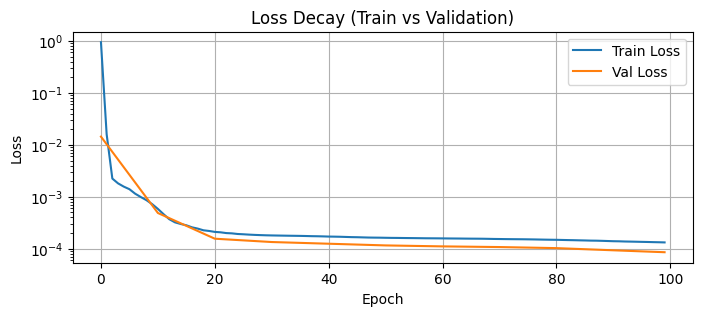

In [25]:
# Plot losses
plt.figure(figsize=(8,3))
plt.semilogy(epo, loss_history, label='Train Loss')
plt.semilogy(epo_val, val_history, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Decay (Train vs Validation)")
plt.grid(True)
plt.show()

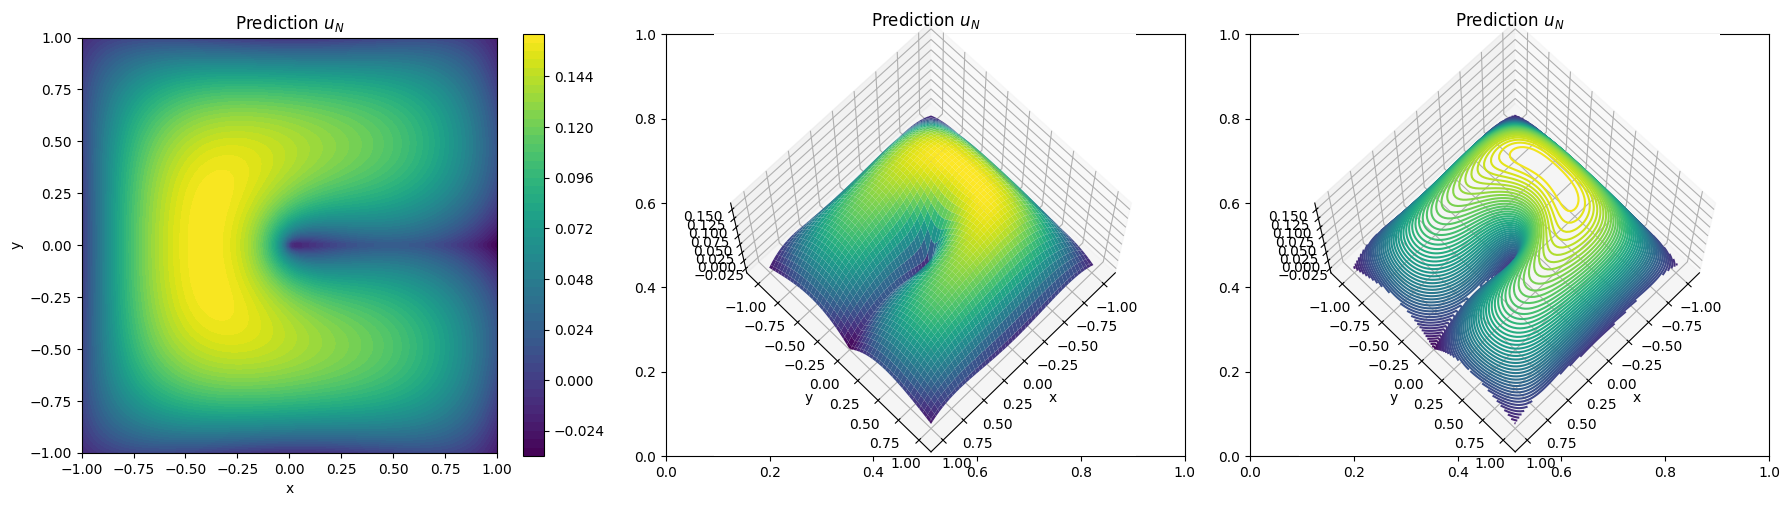

In [26]:
# 測試網格
nx = 100
xs = np.linspace(X_MIN, X_MAX, nx)
ys = np.linspace(Y_MIN, Y_MAX, nx)
Xg, Yg = np.meshgrid(xs, ys)
x_grid = torch.from_numpy(Xg.flatten()[:,None]).to(device).double()
y_grid = torch.from_numpy(Yg.flatten()[:,None]).to(device).double()

# phi(grid)
with torch.no_grad():
    phi_grid = compute_phi(x_grid, y_grid)

# 預測解
with torch.no_grad():
    inp_grid = torch.cat([x_grid, y_grid, phi_grid], dim=1)
    u_pred = model(inp_grid).cpu().numpy().reshape(nx, nx)

# 畫圖 
fig, axs = plt.subplots(1, 3, figsize=(18,5))

im0 = axs[0].contourf(Xg, Yg, u_pred, 50, cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title('Prediction $u_N$')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')  #x, y 軸比例相同

axs[1] = fig.add_subplot(132, projection='3d')
im0 = axs[1].plot_surface(Xg, Yg, u_pred, cmap='viridis', edgecolor='none')
#fig.colorbar(im0, ax=axs[1], shrink=0.5, aspect=10)
axs[1].set_title('Prediction $u_N$')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
#axs[1].set_aspect('equal')  #x, y 軸比例相同
axs[1].view_init(elev=70, azim=45)

axs[2] = fig.add_subplot(133, projection='3d')
im1 = axs[2].contour3D(Xg, Yg, u_pred, 50, cmap='viridis')
#fig.colorbar(im1, ax=axs[2], shrink=0.5, aspect=10)
axs[2].set_title('Prediction $u_N$')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
#axs[2].set_aspect('equal')  #x, y 軸比例相同
axs[2].view_init(elev=70, azim=45)

plt.tight_layout()
plt.show()

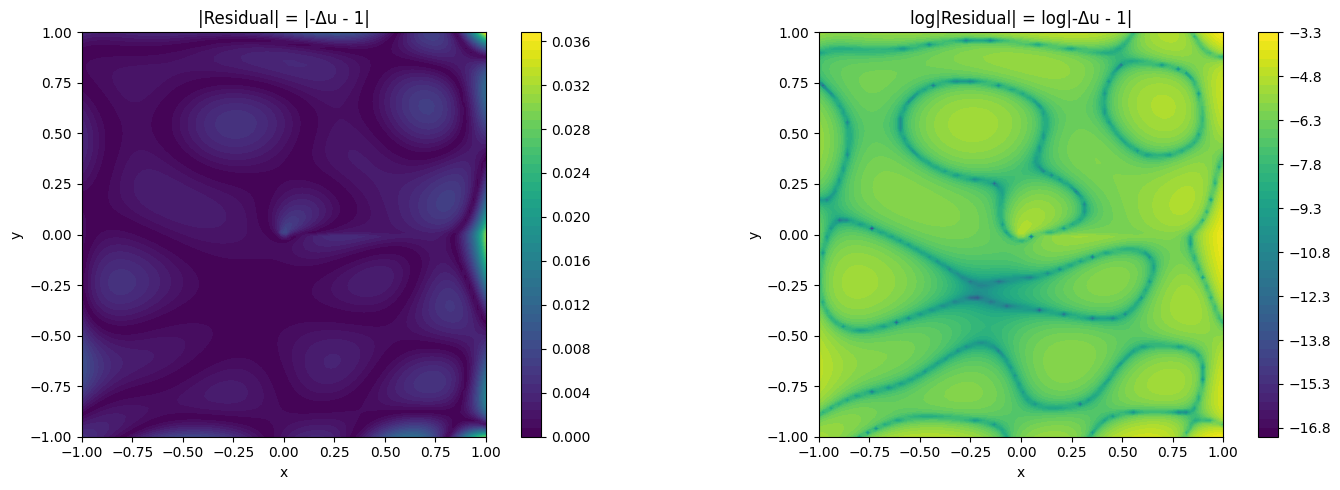

In [ ]:
lap_u = compute_laplace_uN(model, x_grid, y_grid) 
residual = -lap_u - 1
abs_residual = torch.abs(residual).detach().cpu().numpy()
log_abs_residual = torch.log(torch.abs(residual)).detach().cpu().numpy()
abs_residual = abs_residual.reshape(Xg.shape)
log_abs_residual = log_abs_residual.reshape(Xg.shape)

fig, axs = plt.subplots(1, 2, figsize=(15,5))

im0 = axs[0].contourf(Xg, Yg, abs_residual, 50, cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title('|Residual| = |-Δu - 1|')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')

im1 = axs[1].contourf(Xg, Yg, log_abs_residual, 50, cmap='viridis')
fig.colorbar(im1, ax=axs[1])
axs[1].set_title('log|Residual| = log|-Δu - 1|')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()